In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def filter_pajeng(pajeng_output):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(b'State')]
    return b'\n'.join(lines)

def read_mpi_csv(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function'],
                  filter_func=filter_pajeng)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    df['rank'] = df['rank'].abs()  # for some reason, Simgrid uses rank-42 and not rankd42
    df['function'] = df['function'].str.replace('PMPI', 'MPI')  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    return df

def read_archive(archive_name, mode, max_time):
    print('# Mode: %s' % mode)
    blas_trace = read_csv(archive_name, 'trace_blas_0.csv')
    print('\tBLAS trace: %6d lines' % len(blas_trace))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace = blas_trace[['function', 'start', 'end', 'rank']]
    blas_trace['kind'] = 'BLAS'
    mpi_trace = read_mpi_csv(archive_name, 'trace_mpi_0.csv')
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[df['end'] <= max_time]
    print('\tRemoved %d events that happened after the resolution (e.g., HPL verifications)' % (old_len - len(df)))
    return df

reality_file = 'grenoble_2018-10-19_1813087.zip'
simgrid_file = '../smpi_hpl/grenoble_2018-10-19_1813088.zip'

simgrid_time = read_csv(simgrid_file, 'results.csv')['time'].unique()
reality_time = read_csv(reality_file, 'results.csv')['time'].unique()
assert len(simgrid_time) == 1 and len(reality_time) == 1
simgrid_time = simgrid_time[0]
reality_time = reality_time[0]

trace_reality = read_archive(reality_file, 'reality', reality_time)
trace_simgrid = read_archive(simgrid_file, 'simgrid', simgrid_time)
traces = pandas.concat([trace_reality, trace_simgrid])

traces.head()

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Mode: reality
	BLAS trace:  34954 lines
	MPI  trace: 191108 lines
	Removed 111459 events that happened after the resolution (e.g., HPL verifications)
# Mode: simgrid
	BLAS trace:  27898 lines
	MPI  trace: 175547 lines
	Removed 1275 events that happened after the resolution (e.g., HPL verifications)


,function,start,end,rank,kind,mode,rank+1
0,dtrsm,-0.000039,0.000000,0,BLAS,reality,1
1,dgemm,0.000011,0.000139,0,BLAS,reality,1
2,dtrsm,0.000324,0.000325,0,BLAS,reality,1
3,dgemm,0.000328,0.000329,0,BLAS,reality,1
4,dtrsm,0.000332,0.000333,0,BLAS,reality,1


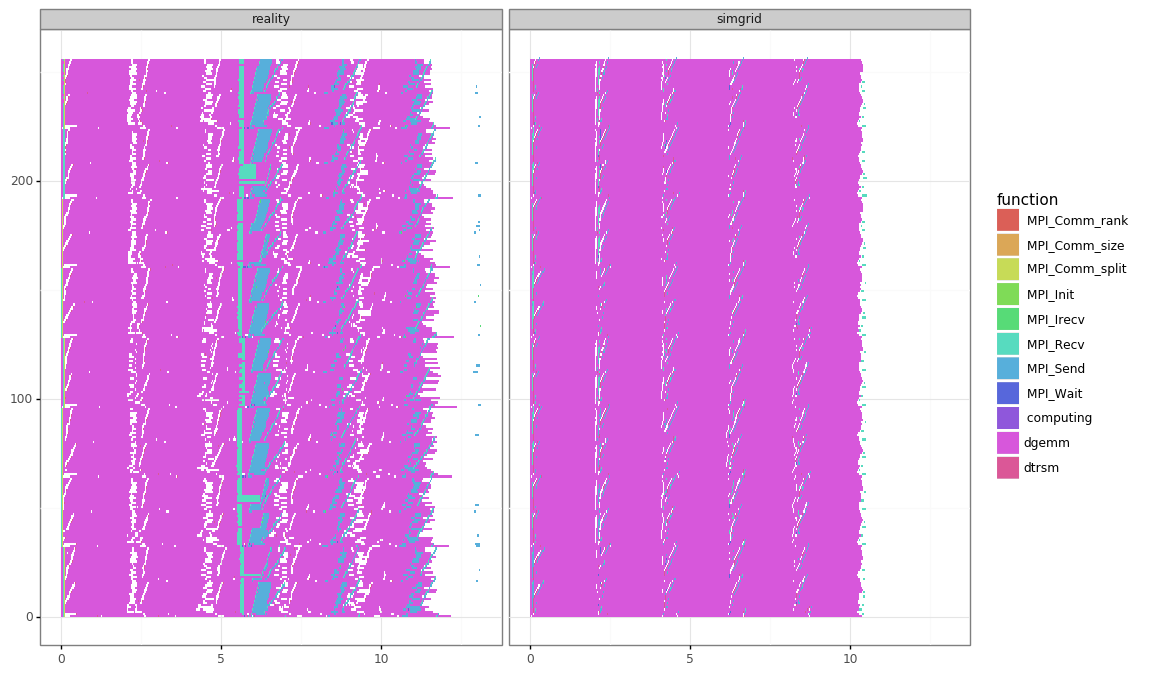

<ggplot: (-9223363288491459836)>

In [2]:
def plot(df, wrap=['mode', 'kind']):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) + facet_wrap(wrap) + theme_bw()
    return gc

plot(traces, ['mode'])

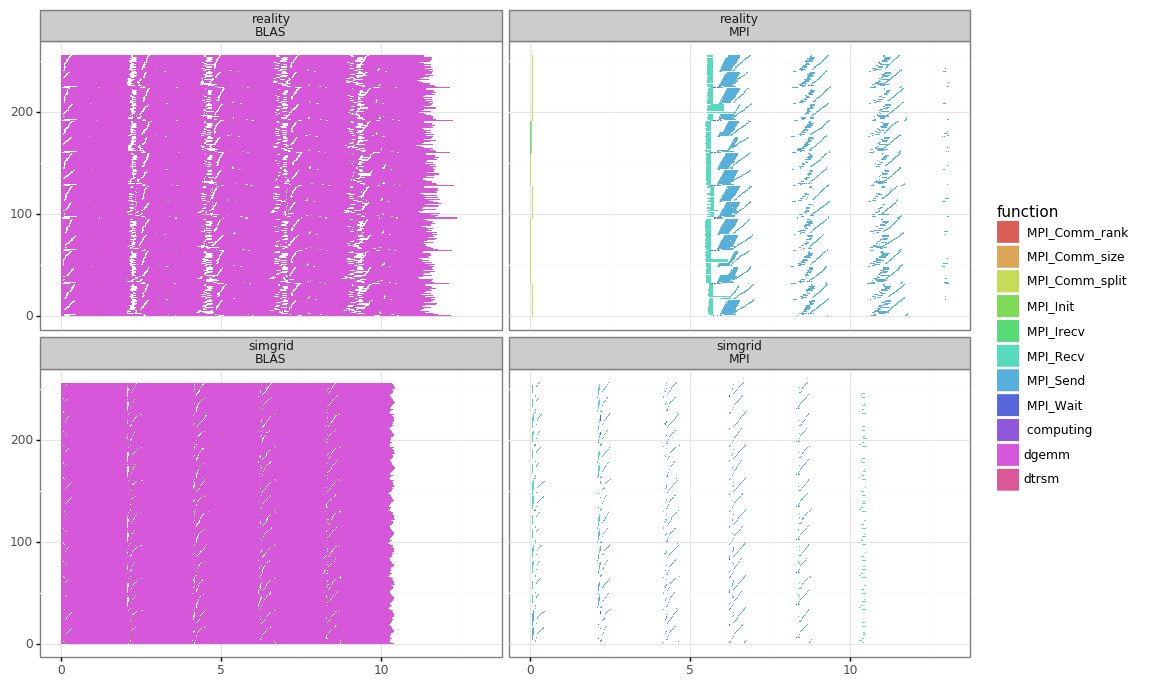

<ggplot: (8748258355611)>

In [3]:
plot(traces)

In [4]:
def plot_bounded(df, start, end, ranks):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

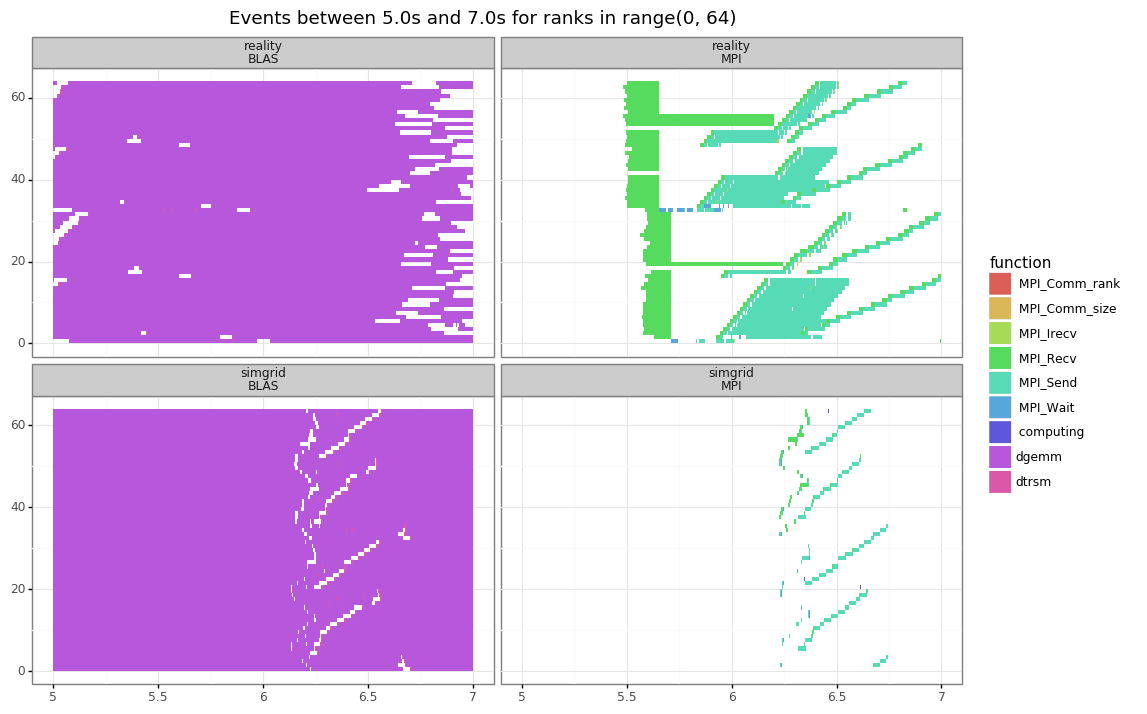

<ggplot: (-9223363288590080291)>

In [5]:
plot_bounded(traces, 5, 7, range(64))

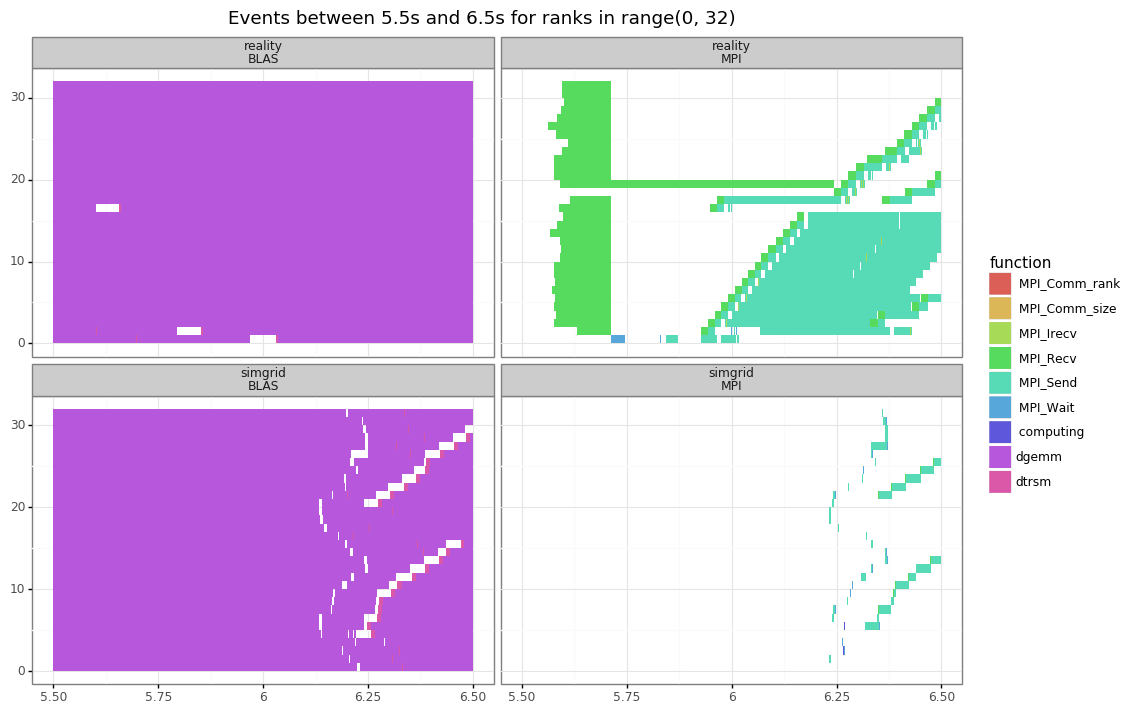

<ggplot: (-9223363288597079443)>

In [6]:
plot_bounded(traces, 5.5, 6.5, range(32))